# Install & Import Necessary Libraries

In [236]:
%%capture output
%pip install notebook pandas matplotlib scipy seaborn scikit-learn numpy

In [237]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime
import pyscopgg2

In [ ]:

class Conn():
    def __init__(self):
        self.state = True

    def _db(self):
        return psycopg2.connect(
            host="37.16.30.221",
            port=5432,
            database="ihappy",
            user="postgres",
            password="eBk5hXOD2v0z5Ih"
        )
    
    def execute(self, query):
        conn = self._db()
        cursor = conn.cursor()
        cursor.execute(query=query)
        res = cursor.fetchall()
        cursor.close()
        conn.close()
        return res

# Retrieve Data from Database

In [238]:

conn = Conn()
query = """SELECT timestamp, a_anger, a_anxiety, a_awareness, a_fear, a_joy, a_mindfulness, a_motivation, a_striking, a_social, a_mindfulness_event FROM public.survey WHERE uid=5;"""
res = conn.execute(query)

In [239]:
headers = ["ts", "anger", "anxienty", "awareness", "fear", "joy", "mindfulness","motivation", "event_striking", "event_social", "event_mindfulness"]
df = pd.DataFrame(res, columns=headers)
df.shape

(16, 11)

## Define variables

In [240]:
ctv = ["anger", "anxienty", "awareness", "fear", "joy", "mindfulness","motivation"]
btv = ["event_striking", "event_social", "event_mindfulness"]

## Preprocessing

In [241]:
df["event_striking"] = df["event_striking"].map({True : 1, False : 0})
df["event_social"] = df["event_social"].map({True : 1, False : 0})
df["event_mindfulness"] = df["event_mindfulness"].map({True : 1, False : 0})
df["ts_diff_min"] = df["ts"].diff().fillna(120 * 60) / 60
df["ts_diff_min"] = df["ts_diff_min"].apply(lambda x: float(round(x, 2) / 1440))
df["abs_elapsed_day"] = df["ts"].apply(lambda x: float((datetime.datetime.now().timestamp() - float(x))/ (1440 * 60)))
df['date'] = df['ts'].apply(lambda x: datetime.datetime.fromtimestamp(float(x)).strftime('%Y-%m-%d'))
df.tail()

,ts,anger,anxienty,awareness,fear,joy,mindfulness,motivation,event_striking,event_social,event_mindfulness,ts_diff_min,abs_elapsed_day,date
11,1735323641.063062,3,2,3,3,9,8,9,1,1,1,0.481181,7.907542,2024-12-27
12,1735463798.335643,5,4,3,5,6,4,7,0,1,1,1.622187,6.285351,2024-12-29
13,1735502136.468935,0,0,2,0,10,10,10,1,1,1,0.443729,5.841623,2024-12-29
14,1735833122.238807,2,2,3,2,9,9,7,0,1,1,3.830854,2.010769,2025-01-02
15,1735914199.934682,5,8,3,2,5,6,4,1,0,0,0.938396,1.072370,2025-01-03


In [242]:
round(df.shape[0] / len(df["date"].unique()),2)

1.45

In [250]:
dfm = pd.DataFrame()
col = []
for dfg in df.groupby(by='date'):
   col.append(dfg[0])
   dfm =  pd.concat([dfm, dfg[1][ctv].mean()], axis=1)
dfm.columns = col

In [251]:
dfm

,2024-12-13,2024-12-14,2024-12-15,2024-12-20,2024-12-22,2024-12-25,2024-12-26,2024-12-27,2024-12-29,2025-01-02,2025-01-03
anger,6.0,2.0,2.333333,7.5,3.0,6.0,7.0,2.0,2.5,2.0,5.0
anxienty,4.0,2.0,3.666667,7.0,7.0,5.0,6.0,2.0,2.0,2.0,8.0
awareness,7.0,4.0,4.000000,6.5,5.0,5.0,4.0,2.5,2.5,3.0,3.0
fear,3.0,2.0,3.000000,6.5,4.0,4.0,3.0,2.0,2.5,2.0,2.0
joy,5.0,6.0,5.666667,2.0,7.0,3.0,8.0,9.0,8.0,9.0,5.0
mindfulness,4.0,6.0,6.000000,2.5,4.0,8.0,5.0,7.5,7.0,9.0,6.0
motivation,5.0,7.0,7.333333,2.0,2.0,3.0,3.0,9.5,8.5,7.0,4.0


In [198]:
df.dtypes

ts                    object
anger                  int64
anxienty               int64
awareness              int64
fear                   int64
joy                    int64
mindfulness            int64
motivation             int64
event_striking         int64
event_social           int64
event_mindfulness      int64
ts_diff_min          float64
abs_elapsed_day      float64
date                  object
dtype: object

# Exploratory Data Analysis

In [ ]:
df[ctv].describe()

,anger,anxienty,awareness,fear,joy,mindfulness,motivation
count,16.000000,16.00000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,3.875000,4.18750,4.125000,3.187500,6.125000,5.875000,5.812500
std,2.418677,2.53558,1.668333,2.104559,2.629956,2.390955,2.880249
min,0.000000,0.00000,2.000000,0.000000,1.000000,2.000000,1.000000
25%,2.000000,2.00000,3.000000,2.000000,4.500000,4.000000,3.000000
50%,3.000000,4.00000,3.500000,3.000000,6.500000,6.000000,6.500000
75%,6.000000,6.00000,5.250000,4.000000,8.250000,8.000000,8.000000
max,8.000000,9.00000,7.000000,9.000000,10.000000,10.000000,10.000000


In [ ]:
pd.concat([df[btv].mean(),df[btv].std()], axis=1).transpose()

,event_striking,event_social,event_mindfulness
0,0.625,0.750000,0.812500
1,0.500,0.447214,0.403113


<Axes: ylabel='Frequency'>

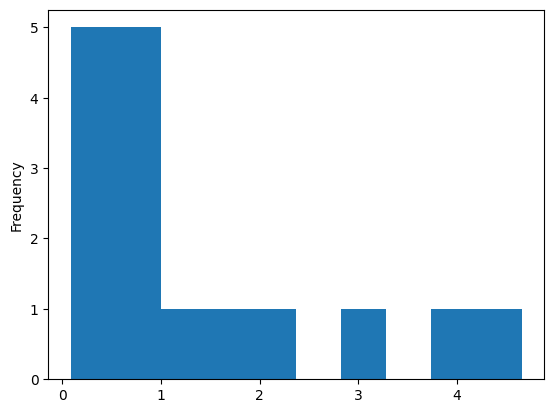

In [201]:
df["ts_diff_min"].plot(kind='hist')

In [202]:
print("Aveage number of submissions per day:")
print(f"{round(1 / df['ts_diff_min'].mean(),2)}")

Aveage number of submissions per day:
0.76


<Axes: xlabel='abs_elapsed_day'>

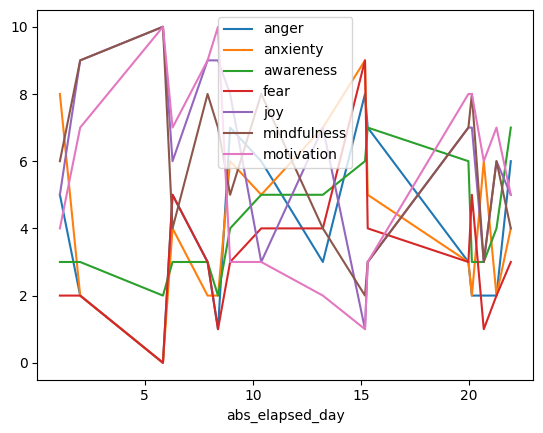

In [203]:
df.plot(kind='line', x="abs_elapsed_day", y=["anger", "anxienty", "awareness", "fear", "joy", "mindfulness","motivation"])

In [204]:
def slide_mean(data : pd.DataFrame, headers, window_length = 3):
    part_df = df[headers]
    append = pd.concat([data[headers].mean() for x in range(0, window_length)], axis=1).transpose()
    ret = pd.concat([append, part_df, append]).reset_index()
    ret = ret.drop("index", axis=1)
    res = pd.DataFrame()
    for i in range(0, ret.shape[0] - window_length + 1):
        res = pd.concat([res, ret[i:i + window_length].mean()], axis=1)
    res = res.transpose().reset_index()
    res = res.drop("index", axis=1)
    return res

<Axes: >

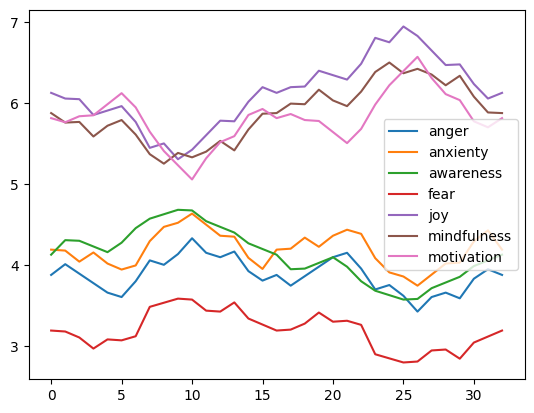

In [ ]:
slide_df = slide_mean(df, ["anger", "anxienty", "awareness", "fear", "joy", "mindfulness","motivation"], window_length=df.shape[0])
slide_df.plot(kind='line', y=["anger", "anxienty", "awareness", "fear", "joy", "mindfulness","motivation"])

<Axes: >

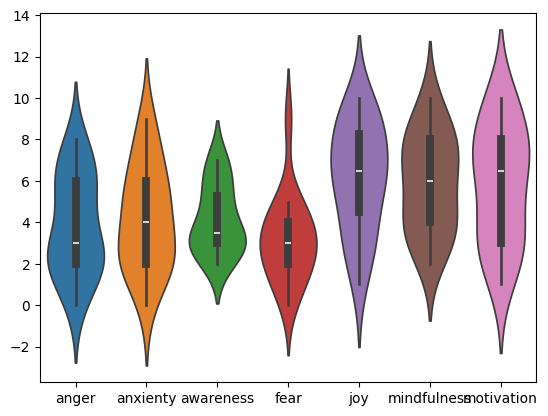

In [ ]:
sns.violinplot(data=df[ctv])

<Axes: >

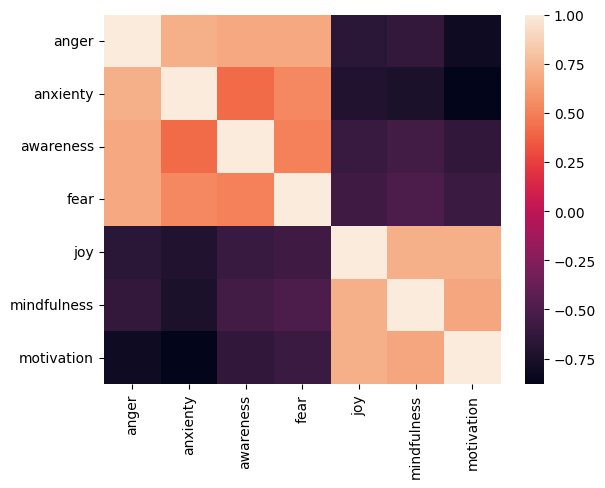

In [ ]:
corr = df[ctv].corr()
sns.heatmap(corr)

In [ ]:
corr

,anger,anxienty,awareness,fear,joy,mindfulness,motivation
anger,1.000000,0.710665,0.681510,0.672855,-0.668132,-0.625402,-0.807448
anxienty,0.710665,1.000000,0.419603,0.530176,-0.713558,-0.743648,-0.880334
awareness,0.681510,0.419603,1.000000,0.505539,-0.596372,-0.547351,-0.632993
fear,0.672855,0.530176,0.505539,1.000000,-0.570622,-0.498486,-0.587711
joy,-0.668132,-0.713558,-0.596372,-0.570622,1.000000,0.712986,0.707378
mindfulness,-0.625402,-0.743648,-0.547351,-0.498486,0.712986,1.000000,0.664339
motivation,-0.807448,-0.880334,-0.632993,-0.587711,0.707378,0.664339,1.000000


# Anomaly Detection
## $\chi^2$ Test
$\sum_{1}^{n}Z^2=\chi^2$<br><br>
Summing over n many square of z-scores yield a chi-square distribution with n degrees of freedom. In our dataset, we have 7 continous variables that we can estimate z-scores, thus a $\chi^2$ test with 7 degrees of freedom is employed to see statistically significant submissions.

In [ ]:
ctvz = []
for ctd in ctv:
    df[f"{ctd}_z"] = df[ctd].apply(lambda x: (x-df[ctd].mean()) / df[ctd].std())
    ctvz.append(f"{ctd}_z")
df["stat_chi_7"] = df["anger_z"] ** 2 + df["anxienty_z"] ** 2 + df["awareness_z"] ** 2 + df["fear_z"] ** 2 + df["joy_z"] ** 2 + df["mindfulness_z"] ** 2 + df["motivation_z"] ** 2
df["p_chi_7"] = 1 - stats.chi2.cdf(df["stat_chi_7"], df=7)
anomaly = df[df["p_chi_7"] < (0.05 / df.shape[1])]
anomaly['date'] = anomaly['ts'].apply(lambda x: datetime.datetime.fromtimestamp(float(x)))
anomaly

C:\Users\sinan\AppData\Local\Temp\ipykernel_2536\1660471202.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomaly['date'] = anomaly['ts'].apply(lambda x: datetime.datetime.fromtimestamp(float(x)))


,ts,anger,anxienty,awareness,fear,joy,mindfulness,motivation,event_striking,event_social,...,date,anger_z,anxienty_z,awareness_z,fear_z,joy_z,mindfulness_z,motivation_z,stat_chi_7,p_chi_7
6,1734694320.806405,8,9,6,9,1,2,1,1,0,...,2024-12-20 14:32:00.806405,1.705478,1.897988,1.123877,2.761862,-1.948702,-1.620691,-1.670863,24.617853,0.000887


In [210]:
df["is_chi_significant"] = df["p_chi_7"].apply(lambda x: True if x < 0.05 else False)

<Axes: ylabel='Frequency'>

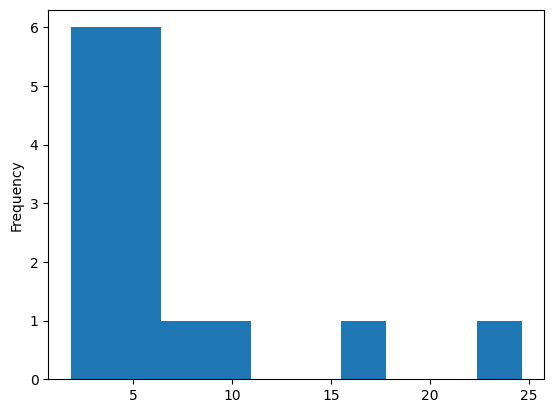

In [211]:
df["stat_chi_7"].plot(kind='hist')

## Principal Component Analysis (PCA)

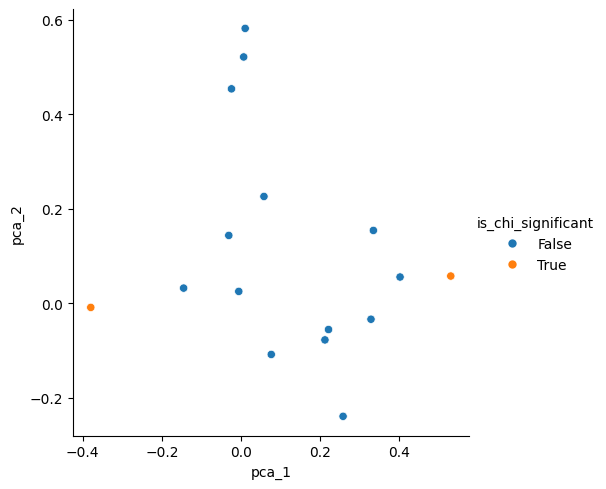

In [212]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df[ctv].transpose())
pc =  pd.DataFrame(pca.components_).transpose()
pc.columns = ["pca_1", "pca_2"]
df = pd.concat([df, pc], axis=1)
sns.relplot(data=df, x="pca_1", y="pca_2", hue="is_chi_significant")

In [213]:
df[df["pca_2"] > 0.4][ctv]

,anger,anxienty,awareness,fear,joy,mindfulness,motivation
7,3,7,5,4,7,4,2
9,7,6,4,3,8,5,3
15,5,8,3,2,5,6,4


In [214]:
df[df["pca_2"] > 0.4][ctvz]

,anger_z,anxienty_z,awareness_z,fear_z,joy_z,mindfulness_z,motivation_z
7,-0.361768,1.109214,0.524476,0.386067,0.332705,-0.784205,-1.323670
9,1.292028,0.714827,-0.074925,-0.089092,0.712940,-0.365963,-0.976478
15,0.465130,1.503601,-0.674326,-0.564251,-0.427764,0.052280,-0.629286


<Axes: >

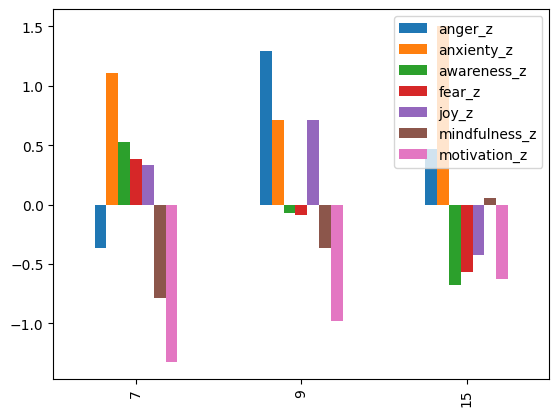

In [215]:
df[df["pca_2"] > 0.4][ctvz].plot(kind='bar')

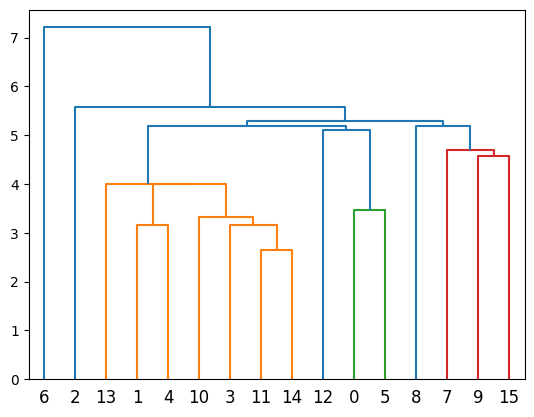

In [216]:
from scipy.cluster import hierarchy
Z = hierarchy.linkage(df[ctv], 'single')
dn = hierarchy.dendrogram(Z)


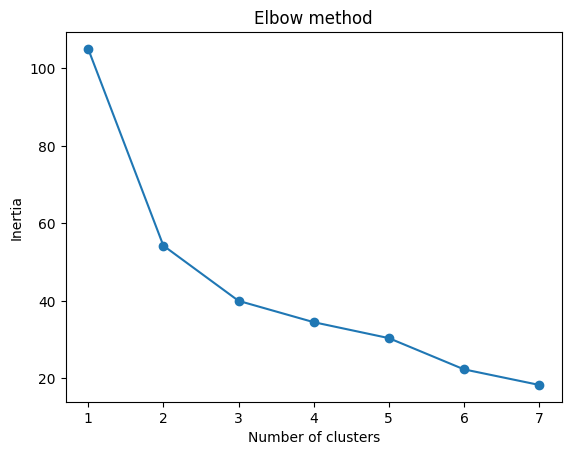

In [ ]:
from sklearn.cluster import KMeans
inertias = []
for i in range(1,8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df[ctvz])
    inertias.append(kmeans.inertia_)

plt.plot(range(1,8), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

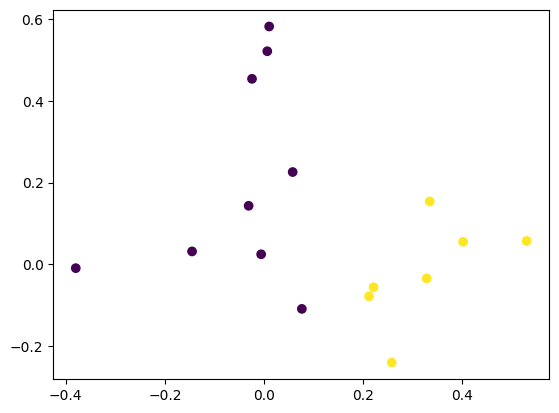

In [218]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(df[ctv])
plt.scatter(df["pca_1"], df["pca_2"], c=kmeans.labels_)
plt.show()

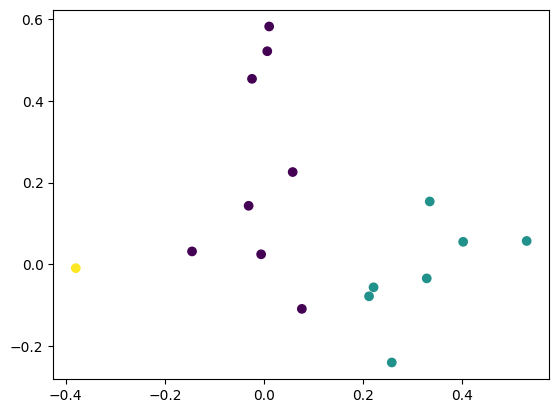

In [219]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df[ctv])
plt.scatter(df["pca_1"], df["pca_2"], c=kmeans.labels_)
plt.show()